# Прогнозирование оттока клиентов в сети отелей

### 1. Файлы с данными

In [167]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, recall_score
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from math import ceil
import numpy as np

In [3]:
train = pd.read_csv('../datasets/hotel_train.csv')
test = pd.read_csv('../datasets/hotel_test.csv')
train.head(3)

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.0,2015,July,27,1,0,1,1.0,...,0,0,0,A,0,0,Transient,0,0,1
1,1,0,14.0,2015,July,27,1,0,2,2.0,...,0,0,0,A,0,0,Transient,0,1,2
2,2,0,0.0,2015,July,27,1,0,2,2.0,...,0,0,0,C,0,0,Transient,0,0,2


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  float64
 12  meal                            

### 2. Предобработка и исследовательский анализ данных

In [6]:
obj_cols = train.select_dtypes('object').columns

for column in obj_cols:
    print(f'{column}: {train[column].unique()}')
    print()

arrival_date_month: ['July' 'August' 'September' 'October' 'November' 'December' 'January'
 'February' 'March' 'April' 'May' 'June']

meal: ['BB       ' 'FB       ' 'HB       ' 'SC       ' 'SC']

country: ['GBR' 'PRT' 'ESP' 'IRL' 'FRA' 'ROU' 'NOR' 'USA' 'DEU' 'BEL' 'CHE' 'CN'
 'GRC' 'NLD' 'ARG' 'RUS' 'SWE' 'POL' 'EST' 'CZE' 'ITA' 'FIN' 'DNK' 'MOZ'
 'BWA' 'LUX' 'BRA' 'SVN' 'ALB' 'CHN' 'MEX' 'MAR' 'SMR' 'LVA' 'CHL' 'AUT'
 'LTU' 'TUR' 'ISR' 'IND' 'CYM' 'AUS' 'CPV' 'ZWE' 'DZA' 'KOR' 'CRI' 'HUN'
 'TUN' 'ARE' 'HRV' 'HKG' 'IRN' 'GIB' 'JEY' 'URY' 'ZAF' 'COL' 'GGY' 'KWT'
 'CYP' 'KAZ' 'THA' 'DOM' 'NGA' 'BLR' 'VEN' 'UKR' 'ARM' 'JPN' 'LKA' 'MYS'
 'BIH' 'MUS' 'OMN' 'SUR' 'JAM' 'BGR' 'CIV' 'SRB' 'JOR' 'SYR' 'PHL' 'PRI'
 'SGP' 'BDI' 'LBN' 'AGO' 'VNM' 'AZE' 'PLW' 'NZL' 'EGY' 'MDV' 'CMR' 'MLT'
 'SVK' 'MWI' 'STP' 'TWN' 'IDN' 'SEN' 'PER' 'SAU' 'KNA' 'ETH' 'ECU' 'IRQ'
 'AND' 'HND' 'PAK' 'GEO' 'ZMB' 'QAT' 'KHM' 'MCO' 'BGD' 'ISL' 'UZB' 'IMN'
 'TJK' 'NIC' 'BEN' 'MAC' 'VGB' 'TZA' 'GAB' 'MKD' 'TMP' 'GLP' 'KEN'

In [ ]:
float_cols = train.select_dtypes(float).columns
train = train.drop('id', axis=1)
test = test.drop('id', axis=1)

test[obj_cols] = test[obj_cols].apply(lambda col: col.str.strip())
test[float_cols] = test[float_cols].astype(int)
train[obj_cols] = train[obj_cols].apply(lambda col: col.str.strip())
train[float_cols] = train[float_cols].astype(int)

#### Подсчет кардинальности столбцов

In [8]:
for column in obj_cols:
    print(column+':', train[column].nunique())

arrival_date_month: 12
meal: 4
country: 155
distribution_channel: 4
reserved_room_type: 7
customer_type: 4


#### Анализ распределений

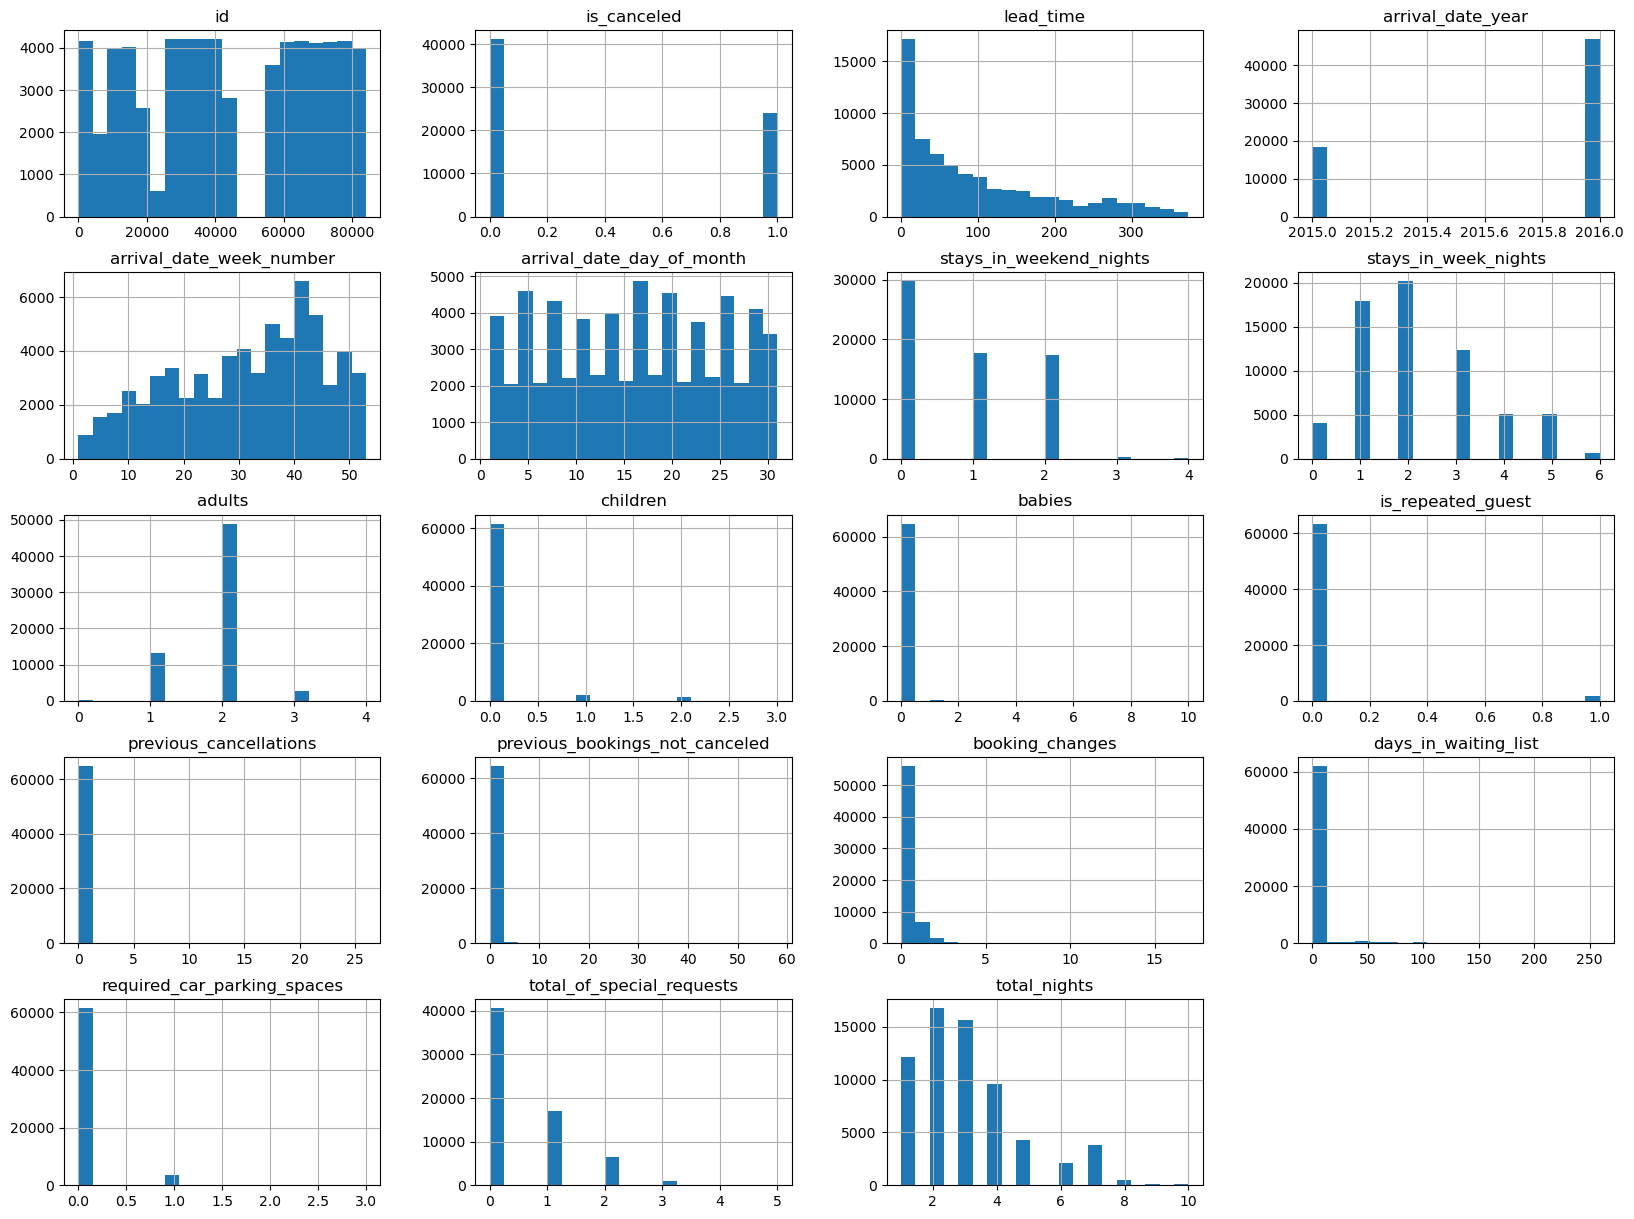

In [10]:
train.hist(figsize=(20, 15), bins=20);

<Axes: >

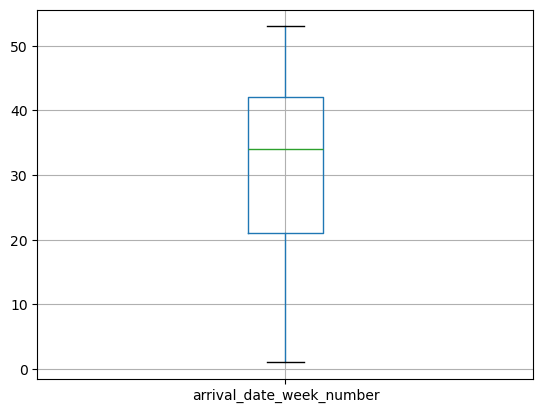

In [11]:
train.boxplot('arrival_date_week_number')

#### Корреляционный анализ

<Axes: >

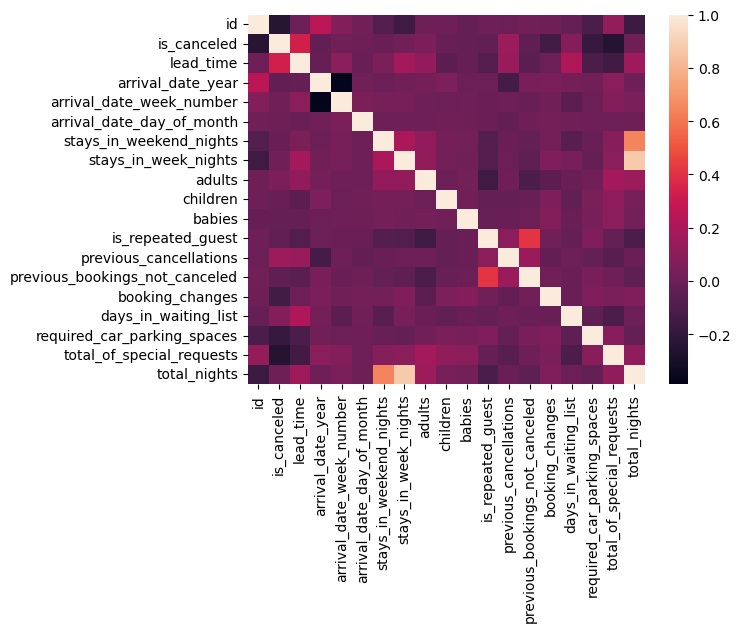

In [12]:
sns.heatmap(train.select_dtypes('number').corr())

### 3. Формулировка ML-задачи на основе бизнес-задачи

#### Подсчет стоимости номера за каждую ночь с учетом сезонного коэффициента

In [136]:
%%time

price_per_room = {'A': 1000, 'B': 800, 'C': 600, 'D': 550, 'E': 500, 'F': 450, 'G': 350}
maintenance_costs = {k: 400 if k == 'A' else 350 if k in 'BC' else 150 for k in 'ABCDEFG'}
seasonal_coeff = {m: 1.4 if m in [6,7,8] else 1.2 if m in [3,4,5,9,10,11] else 1 for m in range(1, 13)}

def get_cost_of_nights(arrival_date, nights, room_type):
    return sum(
        round(seasonal_coeff[(arrival_date + timedelta(days=i)).month] * price_per_room[room_type]) 
        for i in range(nights)
    )
    
def profit_calculation(is_canceled, room_service, total_cost, cost_of_one_night, total_nights):
    if is_canceled: return -(room_service + cost_of_one_night)
    else: return total_cost - room_service * (total_nights if total_nights < 3 else ceil(total_nights / 2))

profit_df = test.copy()

profit_df['room_service'] = profit_df.reserved_room_type.map(maintenance_costs)
profit_df['arrival_date'] = pd.to_datetime(
    profit_df['arrival_date_year'].astype(str) + '-' + 
    profit_df['arrival_date_month'].astype(str) + '-' + 
    profit_df['arrival_date_day_of_month'].astype(str)
)
profit_df['total_cost'] = profit_df.apply(
    lambda row: get_cost_of_nights(row.arrival_date, row.total_nights, row.reserved_room_type),
    axis=1
)
profit_df['cost_of_one_night'] = (
    profit_df.arrival_date.dt.month.map(seasonal_coeff) * profit_df.reserved_room_type.map(price_per_room)
).round().astype(int)

profit_df['profit'] = profit_df.apply(
    lambda row: profit_calculation(
        row.is_canceled, row.room_service, row.total_cost, row.cost_of_one_night, row.total_nights
    ),
    axis=1
)
profit_df

CPU times: total: 2.34 s
Wall time: 2.36 s


,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,room_service,arrival_date,total_cost,cost_of_one_night,profit
0,1,74,2017,January,1,1,1,0,2,0,...,0,Transient,0,0,1,400,2017-01-01,1000,1000,-1400
1,1,62,2017,January,1,1,2,2,2,0,...,0,Transient,0,1,4,400,2017-01-01,4000,1000,-1400
2,1,62,2017,January,1,1,2,2,2,0,...,0,Transient,0,1,4,400,2017-01-01,4000,1000,-1400
3,1,71,2017,January,1,1,2,2,1,0,...,0,Transient,0,1,4,400,2017-01-01,4000,1000,-1400
4,1,172,2017,January,1,1,2,5,2,0,...,0,Transient,0,0,7,400,2017-01-01,7000,1000,-1400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32407,0,164,2017,August,35,31,2,4,2,0,...,0,Transient,0,0,6,400,2017-08-31,7400,1400,6200
32408,0,21,2017,August,35,30,2,5,2,0,...,0,Transient,0,2,7,400,2017-08-30,8800,1400,7200
32409,0,23,2017,August,35,30,2,5,2,0,...,0,Transient,0,0,7,400,2017-08-30,8800,1400,7200
32410,0,34,2017,August,35,31,2,5,2,0,...,0,Transient,0,4,7,150,2017-08-31,4730,770,4130


In [137]:
profit_before = profit_df.profit.sum()
profit_before

np.int64(34021890)

### 4. Разработка модели ML

In [68]:
country_counts = train.country.value_counts(normalize=True)
len(country_counts[country_counts >= 0.01])

13

In [51]:
train_unique = set(train.country.unique())
test_unique = set(test.country.unique())
len(test_unique - train_unique)

19

#### Случайный лес

In [95]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [112]:
%%time

X_train = train.drop('is_canceled', axis=1)
y_train = train.is_canceled
X_test = test.drop('is_canceled', axis=1)
y_test = test.is_canceled

num_cols = X_train.select_dtypes('number').columns

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(drop='first', handle_unknown='infrequent_if_exist', min_frequency=0.01), obj_cols)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=1, class_weight='balanced'))
])

params = {
    'classifier__n_estimators': [140, 150],
    'classifier__max_depth': [3, 4],
    'classifier__min_samples_split': [4, 5]
}

grid = GridSearchCV(pipeline, params, scoring='f1', n_jobs=-1)
grid.fit(X_train, y_train)

forest_model = grid.best_estimator_
grid.best_score_, grid.best_params_

CPU times: total: 6.89 s
Wall time: 1min 20s


(np.float64(0.5942739844985405),
 {'classifier__max_depth': 4,
  'classifier__min_samples_split': 4,
  'classifier__n_estimators': 150})

In [154]:
y_pred = forest_model.predict(X_test)
y_probs = forest_model.predict_proba(X_test)[:, 1]

f1_score(y_test, y_pred), roc_auc_score(y_test, y_probs), recall_score(y_test, y_pred)

(0.6653006681514476, np.float64(0.8313755041943558), 0.5931220713207846)

#### Логистическая регрессия

In [120]:
%%time
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=1, class_weight='balanced'))
])

params = {
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear', 'saga'],
    'classifier__max_iter': [100, 200],
}

grid = GridSearchCV(pipeline, params, scoring='f1', n_jobs=-1)
grid.fit(X_train, y_train)

regression_model = grid.best_estimator_
grid.best_score_, grid.best_params_

CPU times: total: 7.92 s
Wall time: 3min 2s


(np.float64(0.512365508244837),
 {'classifier__max_iter': 100,
  'classifier__penalty': 'l2',
  'classifier__solver': 'saga'})

In [158]:
y_pred = regression_model.predict(X_test)
y_probs = regression_model.predict_proba(X_test)[:, 1]

f1_score(y_test, y_pred), roc_auc_score(y_test, y_probs), recall_score(y_test, y_pred)

(0.6818463545914206, np.float64(0.8206520653551134), 0.8300373282503375)

#### Оценка прибыли отеля

In [170]:
profit_df['is_canceled_predicted'] = y_pred
profit_df['profit_with_model'] = np.where(
    (profit_df['is_canceled'] == 1) & (profit_df['is_canceled_predicted'] == 1),
    profit_df['profit']*0.2,
    profit_df['profit']
)
profit_df

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,required_car_parking_spaces,total_of_special_requests,total_nights,room_service,arrival_date,total_cost,cost_of_one_night,profit,is_canceled_predicted,profit_with_model
0,1,74,2017,January,1,1,1,0,2,0,...,0,0,1,400,2017-01-01,1000,1000,-1400,1,-280.0
1,1,62,2017,January,1,1,2,2,2,0,...,0,1,4,400,2017-01-01,4000,1000,-1400,0,-1400.0
2,1,62,2017,January,1,1,2,2,2,0,...,0,1,4,400,2017-01-01,4000,1000,-1400,0,-1400.0
3,1,71,2017,January,1,1,2,2,1,0,...,0,1,4,400,2017-01-01,4000,1000,-1400,1,-280.0
4,1,172,2017,January,1,1,2,5,2,0,...,0,0,7,400,2017-01-01,7000,1000,-1400,1,-280.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32407,0,164,2017,August,35,31,2,4,2,0,...,0,0,6,400,2017-08-31,7400,1400,6200,1,6200.0
32408,0,21,2017,August,35,30,2,5,2,0,...,0,2,7,400,2017-08-30,8800,1400,7200,0,7200.0
32409,0,23,2017,August,35,30,2,5,2,0,...,0,0,7,400,2017-08-30,8800,1400,7200,1,7200.0
32410,0,34,2017,August,35,31,2,5,2,0,...,0,4,7,150,2017-08-31,4730,770,4130,0,4130.0


In [172]:
profit_after = profit_df.profit_with_model.sum()
profit_after

np.float64(46143482.0)

In [181]:
profit_after - profit_before

np.float64(12121592.0)

затраты на разработку модели (400 000) полностью окупаются

### 5. Портрет «ненадёжного» клиента

In [183]:
train.groupby('customer_type')['is_canceled'].mean().sort_values(ascending=False)

customer_type
Contract           0.396941
Transient          0.396039
Transient-Party    0.294139
Group              0.083624
Name: is_canceled, dtype: float64

In [188]:
train.groupby('previous_cancellations').is_canceled.mean().sort_values(ascending=False)

previous_cancellations
6     1.000000
26    1.000000
25    1.000000
21    1.000000
24    1.000000
14    1.000000
19    1.000000
1     0.974846
13    0.916667
2     0.425926
3     0.313725
0     0.312933
11    0.285714
4     0.200000
5     0.153846
Name: is_canceled, dtype: float64

### 6. Напишите общий вывод

да